In [ ]:
#hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#default_exp data

# Data

> Methods to load time series data from motion files

In [ ]:
#export
from mlchaos.imports import * 
from fastcore.all import *
from timeseries.all import *
import pandas as pd
import numpy as np
from mlchaos.utils import df_slicer
from plotnine import *

In [ ]:
base_path = Path.home()

## Motions defined in files Poincare.plt and index.plt

We call an `item` as a pair `(fname_poincare, fname_index)`. From the Poincare file we get the data of the time series (the x or independent variable) and from the index file we get the y or dependent variable

### Load motion data from poincare file (independent variables)

In [ ]:
#export
def load_poincare_maps(fname:Path):
    "Load the data from a Poincare map.\
    Returns a numpy array with a shape (n_orbits, 2, sequence_length). \
    The time column is removed from the data, since it is always multiples of 2*pi"
    df = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])
    seq_length = set(df.time).__len__()
    df = df.drop('time', axis=1)
    nparr = df_slicer(df, w=seq_length, s=seq_length)
    return nparr.transpose([0, 2, 1])

In [ ]:
fname = Path('../example_data/Poincare.plt')
foo = load_poincare_maps(fname)
bar = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])

In [ ]:
seq_len = set(bar.time).__len__()
test_eq(foo.shape[2], seq_len)

In [ ]:
test_eq(foo.shape[0], bar.shape[0]/seq_len)

In [ ]:
test_eq(foo[0,:,:], bar.drop('time', axis=1)[:seq_len].values.transpose(1,0))

### Load index of the motion from index file (dependent variable)

In [ ]:
#export
def load_index_file(fname:Path, index_col=7, multiindex_handler=None, uncertainty_index=-1.):
    r"""
    Returns the index of an index file. In case the argument `index_col` has 
    more than one value (i.e., it's a list), the argument `multiindex_handler`
    will indicate what to do. Possible values are:
        * None: Do nothing
        * 'uncertainty': Set the value `uncertainty_index` as index of that row
        * 'random': Randomly sample one index from the multiple options.
    """
    indices = pd.read_table(fname,
                         sep='\s+',
                         header=None,
                         usecols=L(index_col),
                         squeeze=True).values
    # indices is a numpy array
    if len(indices.shape) > 1:
        if multiindex_handler == 'uncertainty':
            indices = array([x[0] if np.all(x == x[0]) else uncertainty_index 
                             for x in indices])
        elif multiindex_handler == 'random':
            # Randomly choose one index for each row
            idx_msk = np.random.choice(indices.shape[1], indices.shape[0])
            indices = np.choose(idx_msk, indices.T)
    return indices

In [ ]:
fname = Path('../example_data/index.plt')

In [ ]:
foo = load_index_file(fname)
test_eq(foo.__class__, np.ndarray)
test_eq(foo.ndim, 1)

Test different multi index handlers

In [ ]:
foo = load_index_file(fname, index_col=[7,8]) # None
bar = load_index_file(fname, index_col=[7,8], multiindex_handler='uncertainty')
baz = load_index_file(fname, index_col=[7,8], multiindex_handler='random')
test_eq(foo.ndim, 2)
test_eq(bar.ndim, 1)
test_eq(baz.ndim, 1)

### Load x and y at once from both the Poincare and the index file

In [ ]:
#export
@delegates(to=load_index_file, but=['fname'])
def load_poincare_index_pair(fname_poincare:Path, fname_index:Path, **kwargs):
    "Load the x data from a Poincare file and the y data from the index file.\
    If multiple indices are used form the indices file, each sample of the poincare file \
    is replicated once for every possible index associated to every motion. \
    Returns a tuple of 2 numpy arrays: "
    "x : array with a shape (n_samples, n_channels, sequence_length)"
    "y : array with a shape (n_samples)"
    "for the Poincare maps, n_channels is 2 (x and y)"
    x = load_poincare_maps(fname_poincare)
    y = load_index_file(fname_index, **kwargs)
    if y.ndim > 1:
        # Replicate each sample for each index value and assign one index to each replica
        x = x.repeat(y.shape[1], axis=0)
        y = y.flatten()
    return (x, y)

In [ ]:
fname_poincare = Path('../example_data/Poincare.plt')
fname_index = Path('../example_data/index.plt')

In [ ]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index)
test_eq(foo.__class__, np.ndarray)
test_eq(bar.__class__, np.ndarray)
test_eq(len(foo), len(bar))

In [ ]:
foo, bar = load_poincare_index_pair(fname_poincare, fname_index, index_col=[7,8])
test_eq(len(foo), len(bar))
test_eq(bar.ndim, 1)

### Create TSData object from a list of (Poincare.plt, index.plt) files

In [ ]:
#export
class TSDataChaos(TSData):
    @classmethod
    @delegates(to=load_poincare_index_pair)
    def from_poincare_and_index_files(cls, fnames, **kwargs):
        "`fnames` is a list of pairs (poincare_file, index_file), or a single pair."
        self = cls(fnames)
        self.x = []
        self.y = []
        self.dsname = []
        self.fnames = []
        self.ds = []
        xs,ys, dss = [],[],[]
        if isinstance(fnames, L) or isinstance(fnames, list):
            for i, (fn_poincare, fn_index) in enumerate(fnames):
                fn_poincare, fn_index = Path(fn_poincare), Path(fn_index)
                dsname = fn_poincare.parent.name
                x, y = load_poincare_index_pair(fn_poincare, fn_index, **kwargs)
                xs.append(x)
                ys.append(y)
                dss.append(np.repeat(i, len(y))) # Map each item with the dataset it belongs to
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(dsname)
            self.x = np.concatenate(xs)
            self.y = np.concatenate(ys)
            self.ds = np.concatenate(dss).squeeze()
        else:
            fn_poincare, fn_index = Path(fnames[0]), Path(fnames[1])
            dsname = fn_poincare.parent.name
            self.fnames.append(fnames)
            self.dsname.append(dsname)
            self.x, self.y = load_poincare_index_pair(fn_poincare, fn_index, **kwargs)
            self.ds = np.repeat(0, len(self.y))
        return self

    @classmethod
    def from_poincare_maps(cls, fnames):
        "`fnames` is a list of paths to Poincare maps. No ys are provided"
        self = cls(fnames)
        self.x = []
        self.y = None
        self.dsname = []
        self.fnames = []
        xs = []
        if isinstance(fnames, list):
            for fn_poincare in fnames:
                x = load_poincare_maps(fn_poincare)
                xs.append(x)
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(fn_poincare.parent.name)
            self.x = np.concatenate(xs)
        else:
            fn_poincare = fnames
            self.fnames.append(fn_poincare)
            self.dsname.append(fn_poincare.parent.name)
            self.x = load_poincare_maps(fn_poincare)
        return self

In [ ]:
fnames = (Path('../example_data/Poincare.plt'), 
            Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames, index_col=5)
foo

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [ ]:
test_eq(foo.__class__, TSDataChaos)

In [ ]:
bar = TSDataChaos.from_poincare_and_index_files(fnames, index_col=8)
bar

TSDataChaos:
 Datasets names (concatenated): ['example_data']
 Filenames:                     [(Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))]
 Data shape: (3, 2, 200)
 Targets shape: (3,)
 Nb Samples: 3
 Nb Channels:           2
 Sequence Length: 200

In [ ]:
x0, y0 = foo.x[0], foo.y[0]
y0

1.0

In [ ]:
test_ne(foo.y, bar.y) 

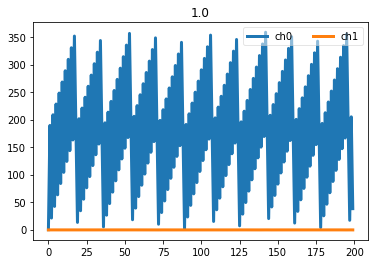

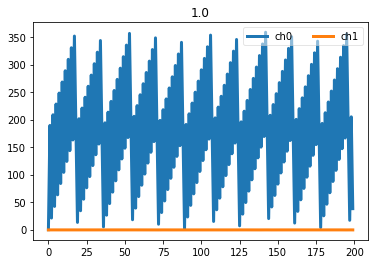

In [ ]:
show_timeseries(x0, title=y0)

### Remove uncertain orbits

In [ ]:
#export
@patch
def remove_uncertainty(self:TSDataChaos, uncertainty_index=-1):
    self.x = self.x[self.y != uncertainty_index]
    self.ds = self.ds[self.y != uncertainty_index]
    self.y = self.y[self.y != uncertainty_index]

In [ ]:
uncertainty_index = -1
fnames = (Path('../example_data/Poincare.plt'), Path('../example_data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames)
test_eq(uncertainty_index in foo.y, True)
foo.remove_uncertainty()
test_eq(uncertainty_index in foo.y, False)

## Get items from a TSDataChaos object

In [ ]:
#export
def get_motion_items(fnames):
    "get_ts_items return list of tuples. Each tuple corresponds \
    to a timeserie (nump.ndarray) and a label (string). fnames is not \
    an array of paths, but an array of tuples of paths. Each tuple has the \
    path of the Poincare map and the path of the index file"
    data = TSDataChaos.from_poincare_and_index_files(fnames)
    return data.get_items()

### Show labelled initial condition map

In [ ]:
#export
def show_labelled_ic_map(poinc_maps:Union[torch.Tensor, np.ndarray], 
                         preds:torch.Tensor, vocab:list=None, show_confidence=False,
                         show_legend=False, color_values=None, **kwargs):
    r"""
    Show a scatter plot with the initial conditions (x0, y0) of each Poincare map in \
    `poinc_maps`, coloured with the labels given in `lbls`.'. The argument `poinc_maps` \
    expects a (n_items, n_channels, n_points) numpy array or tensor. If `show_confidence` is true,
    it will contain the probability distribution of each prediction, which will be
    used to plot each point in the map with higher or level transparency (predictions with
    higher probability will have greater values of transparency)
    """
    ic = poinc_maps[:,:,0]
    data = pd.DataFrame(ic, columns=['x0', 'y0'])
    lbls = torch.argmax(preds, dim=1)
    data['lbl'] = L(lbls, use_list=True).map(lambda o: vocab[o]) if vocab else L(lbls, use_list=True).map(str)
    data['confidence'] = torch.max(preds, dim=1).values
    scale_args = dict()
    # Color values follow the same order of the vocab
    scale_color_layer = scale_color_discrete(**scale_args) if not color_values else scale_color_manual(color_values, **scale_args)
    if not show_legend: scale_args['guide']=False
    res = (
        ggplot(data, aes('x0', 'y0')) + 
        theme_classic()
    )
    if show_confidence:
        res = (res + geom_point(aes('x0','y0', color='lbl', alpha='confidence')) + 
        scale_color_layer + scale_alpha_continuous(**scale_args))
    else:
        res = (res + geom_point(aes('x0','y0', color='lbl')) + scale_color_layer)
    return res

In [ ]:
mock_poinc_map = np.random.randn(1000, 2, 100)
mock_preds = torch.rand(1000, 3)
mock_preds = mock_preds/mock_preds.sum(dim=1)[:, None] # Make the probs sum up 1
vocab = ['chaotic', 'librational', 'rotational']

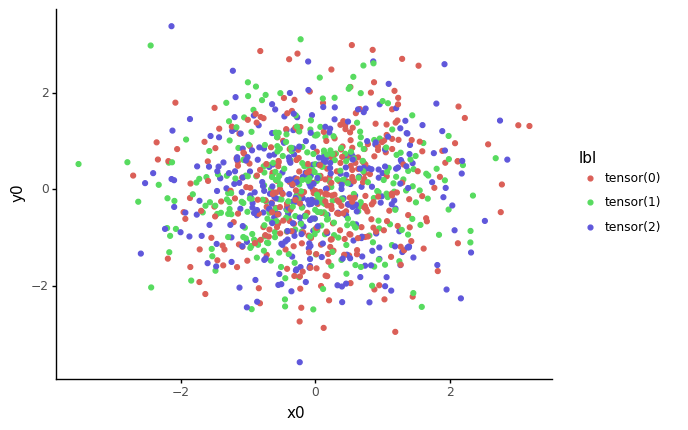

<ggplot: (8778466101501)>

In [ ]:
# NOTE: These FLI plots are completely random
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds)

Try different colors

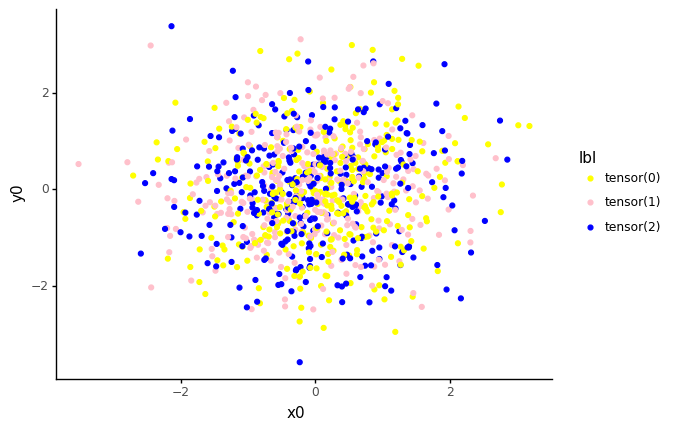

<ggplot: (8778470730259)>

In [ ]:
# NOTE: These FLI plots are completely random
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, 
                     color_values=['yellow', 'pink', 'blue'])

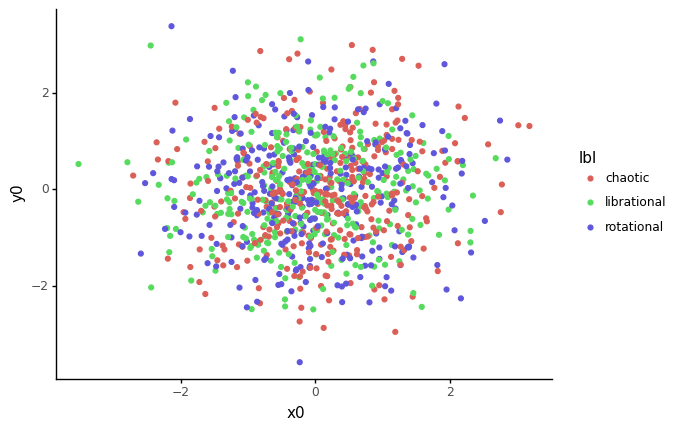

<ggplot: (8778466127397)>

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, 
                     vocab = vocab, show_legend=True)

Test the use of probs to and its visualization through point transparency

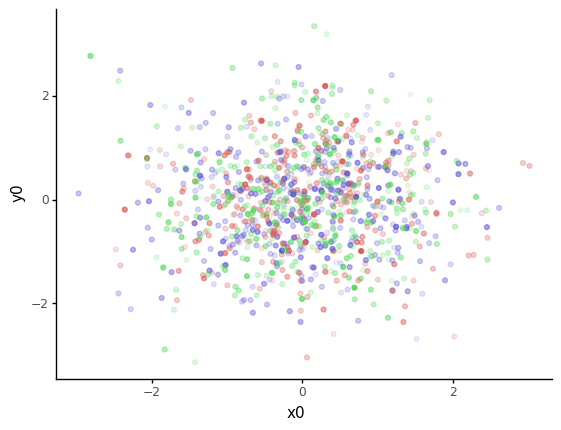

<ggplot: (8778466221460)>

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, show_confidence=True)

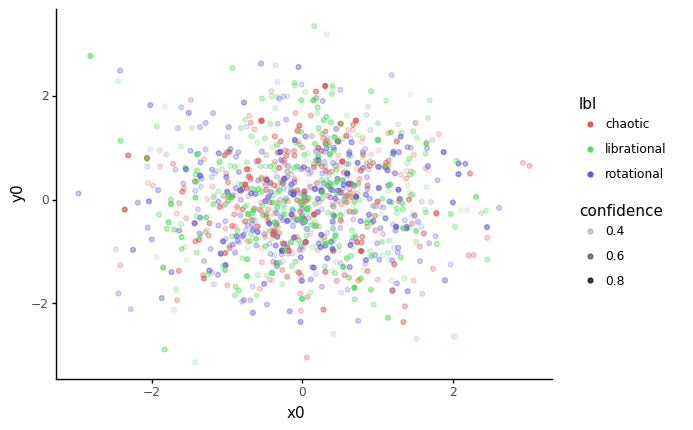

<ggplot: (8778463126667)>

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, vocab=vocab,
                     show_confidence=True, show_legend=True)

Pass kwargs arguments to sns.scatterplot

In [ ]:
show_labelled_ic_map(poinc_maps=mock_poinc_map, preds=mock_preds, legend=False)

In [ ]:
ic = mock_poinc_map[:,:,0]
foo = pd.DataFrame(ic, columns=['x0', 'y0'])
bar = torch.argmax(mock_preds, dim=1)
baz = torch.max(mock_preds, dim=1).values
foo['lbl'] = L(bar, use_list=True).map(lambda o: vocab[o]) if vocab else bar
foo['confidence'] = baz

In [ ]:
quux = (
    ggplot(foo) + geom_point(aes('x0','y0', color='lbl', alpha='confidence')) + 
    theme_classic()
)

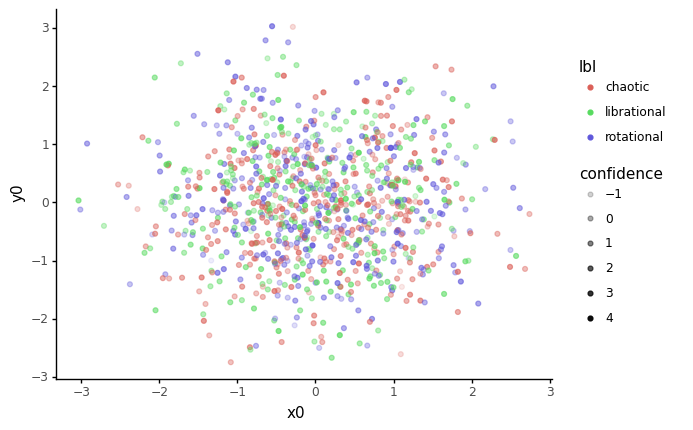

<ggplot: (8778466220087)>

In [ ]:
quux

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
beep(1)

Converted cam.ipynb.
Converted core.ipynb.
Converted data.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
Converted utils.ipynb.
